In [199]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

%matplotlib inline

## Loading the data
We can now load the dataset into pandas using the read_csv() function. This converts the CSV file into a Pandas dataframe.

In [200]:
#Read in the csv file and convert to a Pandas dataframe
df_Football_Players = pd.read_csv("..\..\data\clean_data.csv")

In [201]:
df_Football_Players.shape

(10537, 23)

## Model




### Feature engineering: 

- Feature scaling
- Aggregation
- One hot coding

-------------------

In [202]:
df_Football_Players = df_Football_Players.drop(['name','player'],axis=1)

In [203]:
categorical_features = df_Football_Players.select_dtypes(include=object).columns
numeric_features = df_Football_Players.select_dtypes(include=np.number).columns
categorical_features

Index(['team', 'position'], dtype='object')

In [204]:
for i in categorical_features:
   print (df_Football_Players[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    45
FC Seoul                  43
Gangwon FC                42
Daegu FC                  42
                          ..
FC Barcelona              21
Swansea City              21
West Ham United           20
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1771
Attack Centre-Forward         1316
Goalkeeper                    1206
midfield-CentralMidfield      1130
midfield-DefensiveMidfield     881
Defender Right-Back            852
Defender Left-Back             788
midfield-AttackingMidfield     760
Attack-RightWinger             705
Attack-LeftWinger              703
midfield-RightMidfield         101
midfield-LeftMidfield           99
midfield                        75
Attack-SecondStriker            64
Attack                          53
Defender                        33
Name: count, dtype: int64


In [205]:
# one hot coding for categorical_features
df_Football_Players = pd.get_dummies(df_Football_Players,columns=categorical_features)


In [206]:
df_Football_Players.head()

,Unnamed: 0,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,0,189.0,32.0,104,0.000000,0.000000,0.009585,0.0000,0.0,1.217252,...,False,False,False,True,False,False,False,False,False,False
1,1,196.0,30.0,15,0.000000,0.000000,0.069018,0.0000,0.0,1.242331,...,False,False,False,True,False,False,False,False,False,False
2,3,175.0,25.0,82,0.028090,0.056180,0.224719,0.0000,0.0,0.000000,...,True,False,False,False,False,False,False,False,False,False
3,4,191.0,30.0,63,0.017889,0.017889,0.053667,0.0000,0.0,0.000000,...,True,False,False,False,False,False,False,False,False,False
4,5,194.0,30.0,68,0.037799,0.000000,0.302394,0.0189,0.0,0.000000,...,True,False,False,False,False,False,False,False,False,False


In [207]:
df_Football_Players.shape

(10537, 409)

In [208]:
# Calculate the 35th and 75th percentiles of the current_value
p35 = df_Football_Players['current_value'].quantile(0.35)
p75 = df_Football_Players['current_value'].quantile(0.75)

# Function to categorize current_value
def categorize_value(value):
    if value < p35:
        return 'low value'
    elif value < p75:
        return 'Good value'
    else:
        return 'High value'

# Apply the function to create a new column
df_Football_Players['current_value_category'] = df_Football_Players['current_value'].apply(categorize_value)

df_Football_Players.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df_Football_Players['current_value_category'].value_counts())

current_value_category
Good value    4233
low value     3666
High value    2638
Name: count, dtype: int64


In [209]:
p35, p75

(425000.0, 3000000.0)

In [210]:
df_Football_Players['current_value_category']

0        High value
1        Good value
2        High value
3        High value
4        High value
            ...    
10532     low value
10533     low value
10534     low value
10535     low value
10536     low value
Name: current_value_category, Length: 10537, dtype: object

In [211]:
encoder = LabelEncoder()
df_Football_Players['current_value_category_encoded'] = encoder.fit_transform(df_Football_Players['current_value_category'])  

In [212]:
df_Football_Players['current_value_category_encoded'].value_counts()

current_value_category_encoded
0    4233
2    3666
1    2638
Name: count, dtype: int64

#### 3. Feature selection


In [213]:
correlation = df_Football_Players.corr(numeric_only=True)
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

current_value_category_encoded    1.000000
Unnamed: 0                        0.222160
position_Goalkeeper               0.144159
position_midfield                 0.100639
goals conceded                    0.097965
                                    ...   
age                              -0.120842
days_injured                     -0.148936
games_injured                    -0.158266
minutes played                   -0.242278
appearance                       -0.262094
Name: current_value_category_encoded, Length: 409, dtype: float64


In [214]:
# Set the correlation threshold
threshold = 0.09  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value_category_encoded']) > threshold]['current_value_category_encoded'].index
selected_features

Index(['Unnamed: 0', 'age', 'appearance', 'assists', 'goals conceded',
       'minutes played', 'days_injured', 'games_injured', 'award',
       'position_encoded', 'position_Goalkeeper', 'position_midfield',
       'current_value_category_encoded'],
      dtype='object')

In [215]:
df_Football_Players = df_Football_Players[selected_features]
df_Football_Players.head()

,Unnamed: 0,age,appearance,assists,goals conceded,minutes played,days_injured,games_injured,award,position_encoded,position_Goalkeeper,position_midfield,current_value_category_encoded
0,0,32.0,104,0.000000,1.217252,9390,42,5,13,1,True,False,1
1,1,30.0,15,0.000000,1.242331,1304,510,58,1,1,True,False,0
2,3,25.0,82,0.056180,0.000000,6408,175,22,9,2,False,False,1
3,4,30.0,63,0.017889,0.000000,5031,238,51,21,2,False,False,1
4,5,30.0,68,0.000000,0.000000,4762,148,27,1,2,False,False,1


In [216]:
df_Football_Players.shape

(10537, 13)

### Prepare train and test data


In [217]:
# Prepare data
X = df_Football_Players.drop(['current_value_category_encoded'], axis=1)
y = df_Football_Players['current_value_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=99)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [218]:
X.shape

(10537, 12)

In [219]:
y.shape

(10537,)

### Build the model

In [220]:
model = LogisticRegression()

### Train the Model

In [221]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

### Test the Model


In [222]:
# Predict and evaluate the model
y_pred_test = model.predict(X_test_scaled)

### Interpretation of the Model


In [223]:
# Each row of the model.coef_ matrix tells you how each feature affects being in the corresponding class versus any other class
coeff_df = pd.DataFrame(model.coef_[2],X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Unnamed: 0,0.747340
age,0.180542
appearance,0.346799
assists,-0.126008
goals conceded,0.105074
minutes played,-1.089098
days_injured,0.101402
games_injured,-0.346040
award,-0.373797
position_encoded,-0.212052


In [224]:
model.coef_


array([[ 0.14639884,  0.27492667, -0.10217147, -0.00600129,  0.12856142,
         0.09123505,  0.00357109, -0.00384394, -0.06404084,  0.00567811,
        -0.17725024, -0.02567925],
       [-0.89373911, -0.45546904, -0.24462801,  0.13200971, -0.23363535,
         0.99786333, -0.10497314,  0.34988382,  0.43783771,  0.2063741 ,
         0.02285484, -0.21107771],
       [ 0.74734028,  0.18054237,  0.34679948, -0.12600842,  0.10507392,
        -1.08909838,  0.10140205, -0.34603988, -0.37379687, -0.2120522 ,
         0.1543954 ,  0.23675695]])

In [225]:
print(model.intercept_) 


[ 0.70408743 -0.70503732  0.00094989]


### Evaluating the Model

In [226]:
# our benchmark model
base_model = round(df_Football_Players['current_value_category_encoded'].value_counts()[1]/df_Football_Players.shape[0]*100, 2)
base_model

25.04

#### Accuracy

In [227]:
# Train score
y_pred_train = model.predict(X_train_scaled)
accuracy_Train = accuracy_score(y_train, y_pred_train)
print(f"Train score: {accuracy_Train}")

Train score: 0.6469332067860957


In [228]:
# Test score
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_test
print(f"Test score: {accuracy_test}")

Test score: 0.6238140417457305


##### Confusion matrix


In [229]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix

array([[483, 112, 223],
       [160, 338,  13],
       [249,  36, 494]], dtype=int64)

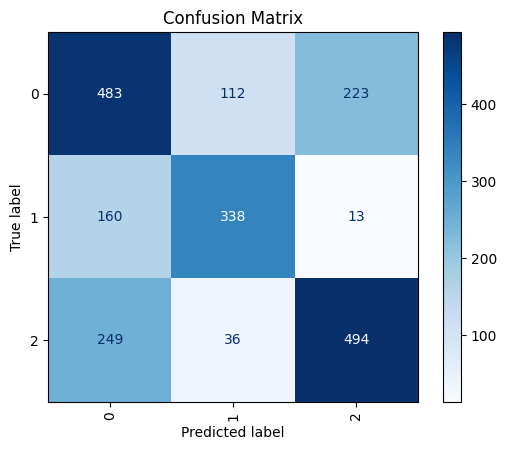

In [230]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

#### Precision

In [231]:
# Train score
precision_train = precision_score(y_train, y_pred_train, average='macro')
print(f"Precision in train: {precision_train:.2f}")

# Test score
precision_test = precision_score(y_test, y_pred_test, average='macro')
print(f"Precision in test: {precision_test:.2f}")

Precision in train: 0.66
Precision in test: 0.64


#### Recall

In [232]:
# Train score
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall in train: {recall_train:.2f}")

# Test score
recall_test = recall_score(y_test, y_pred_test, average='macro')
print(f"Recall in test: {recall_test:.2f}")

Recall in train: 0.65
Recall in test: 0.63


#### F1-Score


In [233]:
# Train score
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"f1-score in train: {f1_train:.2f}")

# Test score
f1_test = precision_score(y_test, y_pred_test, average='macro')
print(f"f1-score in test: {f1_test:.2f}")

f1-score in train: 0.65
f1-score in test: 0.64


### Classification report

In [234]:
from sklearn.metrics import classification_report

print('Train report: ')
print(classification_report(y_train, y_pred_train))

print('Test report: ')
print(classification_report(y_test, y_pred_test))

Train report: 
              precision    recall  f1-score   support

           0       0.59      0.60      0.60      3415
           1       0.71      0.68      0.69      2127
           2       0.67      0.68      0.67      2887

    accuracy                           0.65      8429
   macro avg       0.66      0.65      0.65      8429
weighted avg       0.65      0.65      0.65      8429

Test report: 
              precision    recall  f1-score   support

           0       0.54      0.59      0.56       818
           1       0.70      0.66      0.68       511
           2       0.68      0.63      0.65       779

    accuracy                           0.62      2108
   macro avg       0.64      0.63      0.63      2108
weighted avg       0.63      0.62      0.63      2108

